In [ ]:
import gdown
import tarfile
import os

file_id = '1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG'
output = 'lapa.tar'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

with tarfile.open(output, 'r') as tar:
    tar.extractall(path='lapa')

print("Contents of the extracted folder:")
print(os.listdir('lapa'))

Downloading...
From (original): https://drive.google.com/uc?id=1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG
From (redirected): https://drive.google.com/uc?id=1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG&confirm=t&uuid=15419980-aa65-48fe-a67d-92e532d04dba
To: /content/lapa.tar
100%|██████████| 2.37G/2.37G [00:28<00:00, 84.3MB/s]


Contents of the extracted folder:
['LaPa']


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import os
import numpy as np
import cv2
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from sklearn.metrics import f1_score, jaccard_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

# Set global variables for eyes and eyebrows
image_h = 512
image_w = 512
num_classes = 5  # Only five classes: background, left eyebrow, right eyebrow, left eye, right eye

# RGB Codes and Class Names for selected classes only
rgb_codes = [
    [0, 0, 0],       # background
    [0, 153, 255],   # left eyebrow
    [102, 255, 153], # right eyebrow
    [0, 204, 153],   # left eye
    [255, 255, 102], # right eye
]



classes = ["background", "left eyebrow", "right eyebrow", "left eye", "right eye"]


# Define helper functions
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, limit=None):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*.jpg")))
    train_y = sorted(glob(os.path.join(path, "train", "labels", "*.png")))

    valid_x = sorted(glob(os.path.join(path, "val", "images", "*.jpg")))
    valid_y = sorted(glob(os.path.join(path, "val", "labels", "*.png")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.jpg")))
    test_y = sorted(glob(os.path.join(path, "test", "labels", "*.png")))

    # Limit the dataset size for each split if specified
    if limit:
        train_x, train_y = train_x[:limit], train_y[:limit]
        valid_x, valid_y = valid_x[:limit], valid_y[:limit]
        test_x, test_y = test_x[:limit], test_y[:limit]

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def grayscale_to_rgb(mask, rgb_codes):
    h, w = mask.shape[0], mask.shape[1]
    mask = mask.astype(np.int32)
    output = [rgb_codes[pixel] for pixel in mask.flatten()]
    output = np.reshape(output, (h, w, 3))
    return output

def save_results(image_x, mask, pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = grayscale_to_rgb(mask, rgb_codes)

    pred = np.expand_dims(pred, axis=-1)
    pred = grayscale_to_rgb(pred, rgb_codes)

    line = np.ones((image_x.shape[0], 10, 3)) * 255
    cat_images = np.concatenate([image_x, line, mask, line, pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

def read_image_mask(x, y):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (image_w, image_h)) / 255.0
    x = x.astype(np.float32)

    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (image_w, image_h)).astype(np.int32)

    # Filter for eyes and eyebrow classes, setting all others to background (0)
    y = np.where((y == 2) | (y == 3) | (y == 4) | (y == 5), y - 1, 0)
    return x, y

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()
        return read_image_mask(x, y)

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes)

    image.set_shape([image_h, image_w, 3])
    mask.set_shape([image_h, image_w, num_classes])

    return image, mask

def tf_dataset(X, Y, batch=2):  # Reduced batch size to reduce memory usage
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(buffer_size=500).map(preprocess)
    ds = ds.batch(batch).prefetch(1)
    return ds

# Model definition
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)
    model = Model(inputs, outputs)
    return model

# Directory setup for saving models and logs in Google Drive
model_dir = "/content/drive/MyDrive/ML_Models_aryan"
os.makedirs(model_dir, exist_ok=True)

# Set paths
model_path = os.path.join(model_dir, "model_c9.keras")
csv_path = os.path.join(model_dir, "data_c9.csv")

# Define dataset path (adjust to point to your dataset in Google Drive)
dataset_path = "/content/lapa/LaPa"

# Load a subset of the dataset (limiting to 1000 images per split)
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path, limit=6000)
print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

# Dataset pipeline with reduced batch size
batch_size = 4
train_ds = tf_dataset(train_x, train_y, batch=batch_size)
valid_ds = tf_dataset(valid_x, valid_y, batch=batch_size)

# Build and compile model
input_shape = (image_h, image_w, 3)
model = build_unet(input_shape, num_classes)
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4)
)

# Training callbacks
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path, append=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

# Train the model with reduced epochs
model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=5,
    callbacks=callbacks
)


Train: 6000 - Valid: 2000 - Test: 2000
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - loss: 0.4948
Epoch 1: val_loss improved from inf to 0.07107, saving model to /content/drive/MyDrive/ML_Models_aryan/model_c9.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1598s 1s/step - loss: 0.4946 - val_loss: 0.0711 - learning_rate: 1.0000e-04
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - loss: 0.0572
Epoch 2: val_loss improved from 0.07107 to 0.03947, saving model to /content/drive/MyDrive/ML_Models_aryan/model_c9.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1570s 1s/step - loss: 0.0572 - val_loss: 0.0395 - learning_rate: 1.0000e-04
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - loss: 0.0361
Epoch 3: val_loss improved from 0.03947 to 0.03115, saving model to /content/drive/MyDrive/ML_Models_aryan/model_c9.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1564s 1s/step - loss: 0.0361 - val_loss: 0.0311 - learning_rate: 1.0000e-04
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - loss: 0.030

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


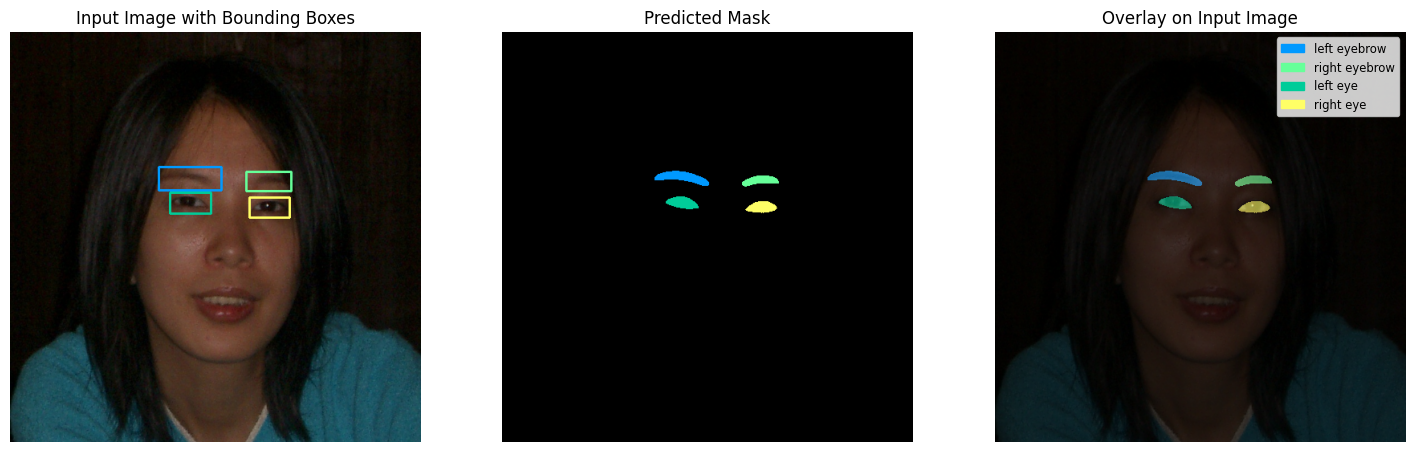

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def predict_and_display_overlay_with_class_bbox(image_path, model, rgb_codes, classes, image_h=512, image_w=512, alpha=0.6, margin=5):
    # Load and preprocess the input image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (image_w, image_h))
    input_image = image / 255.0
    input_image = np.expand_dims(input_image, axis=0).astype(np.float32)

    # Predict segmentation mask
    pred_mask = model.predict(input_image)[0]
    pred_mask = np.argmax(pred_mask, axis=-1).astype(np.int32)

    # Convert prediction mask to RGB
    pred_rgb = grayscale_to_rgb(pred_mask, rgb_codes).astype(np.uint8)

    # Convert image to RGB for display and overlay compatibility
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
    image_with_boxes = image_rgb.copy()  # Copy for bounding box drawing

    # Define bounding box colors for each class
    bbox_colors = [
        (0, 0, 0),         # background - black (optional)
        (0, 153, 255),     # left eyebrow - blue
        (102, 255, 153),   # right eyebrow - green
        (0, 204, 153),     # left eye - teal
        (255, 255, 102)    # right eye - yellow
    ]

    # Draw bounding boxes for each class (excluding background)
    for class_id in range(1, len(classes)):
        # Create a binary mask for the current class
        binary_mask = np.where(pred_mask == class_id, 1, 0).astype(np.uint8)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            x, y = max(0, x - margin), max(0, y - margin)  # Apply margin
            w, h = min(image_w - x, w + 2 * margin), min(image_h - y, h + 2 * margin)  # Ensure bounding box is within image

            # Draw the rectangle on the copied image (without mask) with the class-specific color
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), bbox_colors[class_id], 2)

    # Create an overlay by blending the image and the mask
    overlay = cv2.addWeighted(image_rgb, 1 - alpha, pred_rgb, alpha, 0)

    # Prepare legend
    patches = [mpatches.Patch(color=np.array(bbox_colors[i])/255.0, label=classes[i]) for i in range(1, len(classes))]

    # Display input image with bounding boxes, predicted mask, and overlay with legend
    plt.figure(figsize=(18, 6))

    # Original Image with Bounding Boxes (no mask)
    plt.subplot(1, 3, 1)
    plt.title("Input Image with Bounding Boxes")
    plt.imshow(image_with_boxes)
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_rgb)
    plt.axis("off")

    # Overlay with Legend
    plt.subplot(1, 3, 3)
    plt.title("Overlay on Input Image")
    plt.imshow(overlay)
    plt.legend(handles=patches, loc="upper right", fontsize='small')
    plt.axis("off")

    plt.show()

# Example usage
image_path = "/content/lapa/LaPa/val/images/10024390903_0.jpg"  # Replace with the path to your test image
predict_and_display_overlay_with_class_bbox(image_path, model, rgb_codes, classes)
